# Задание 3   

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR    

При этом метод сам по себе очень прост. Что это за метрика такая?    

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)     
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠     
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠     
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.   


- Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?   
- Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
from tqdm import tqdm

from read_db.CH import Getch

%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})

Наши AB тесты:   
Первый
* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

Второй
* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

Эксперименты проходили с 2022-04-04 по 2022-04-10 включительно. 

## Посмотрим на данные

In [3]:
ab_test_query = """
SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
    FROM simulator_20220420.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (1, 2, 0, 3)
    GROUP BY exp_group, user_id
"""

In [4]:
ab_test_data = Getch(ab_test_query).df

In [5]:
ab_test_data.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,2,32420,26,128,0.203125


In [6]:
# Размеры выборок
ab_test_data.groupby('exp_group').count()[['user_id']]

,user_id
exp_group,
0,9999
1,10079
2,9952
3,10049


In [7]:
ab_test_data_1 = ab_test_data[ab_test_data['exp_group'].isin([1, 2])].copy()
ab_test_data_2 = ab_test_data[ab_test_data['exp_group'].isin([0, 3])].copy()

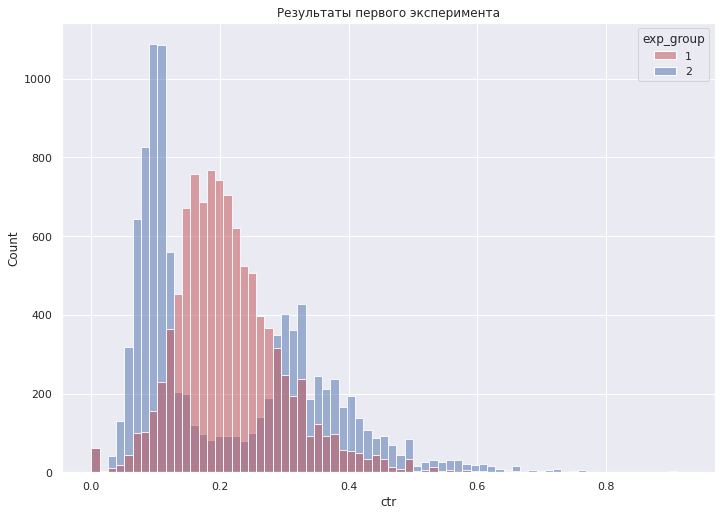

In [8]:
# Первый эксперимент
groups = sns.histplot(
    data=ab_test_data_1, 
    x='ctr', 
    hue='exp_group', 
    palette=['r', 'b'],
    alpha=0.5,
    kde=False
)
plt.title('Результаты первого эксперимента');

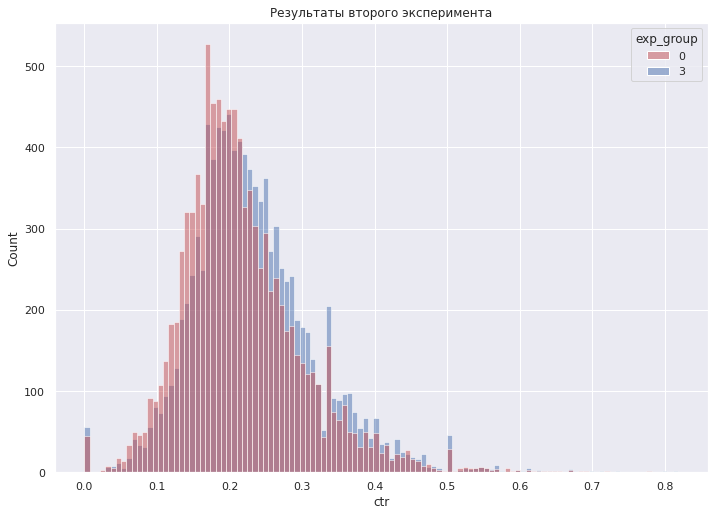

In [9]:
# Второй эксперимент
groups = sns.histplot(
    data=ab_test_data_2, 
    x='ctr', 
    hue='exp_group', 
    palette=['r', 'b'],
    alpha=0.5,
    kde=False
)
plt.title('Результаты второго эксперимента');

## Посчитаем линеаризованные лайки
𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 = 𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠) / 𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)   
𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 = 𝑙𝑖𝑘𝑒𝑠 − 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 ∗ 𝑣𝑖𝑒𝑤𝑠

In [10]:
ctr_control_1 = ab_test_data_1[ab_test_data_1['exp_group'] == 1]['likes'].sum() / ab_test_data_1[ab_test_data_1['exp_group'] == 1]['views'].sum()
ctr_control_2 = ab_test_data_2[ab_test_data_2['exp_group'] == 0]['likes'].sum() / ab_test_data_2[ab_test_data_2['exp_group'] == 0]['views'].sum()

In [11]:
ab_test_data_1['linearized_likes'] = ab_test_data_1['likes'] - ctr_control_1 * ab_test_data_1['views']
ab_test_data_2['linearized_likes'] = ab_test_data_2['likes'] - ctr_control_2 * ab_test_data_2['views']

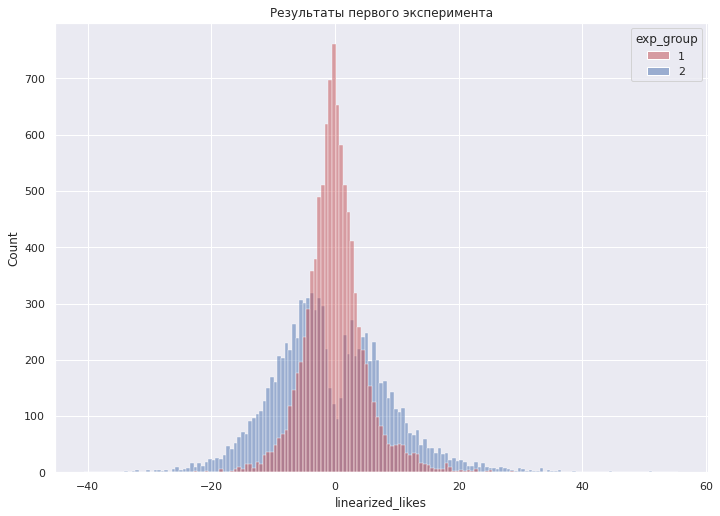

In [12]:
# Посмотрим картинки по новой метрике
groups = sns.histplot(
    data=ab_test_data_1, 
    x='linearized_likes', 
    hue='exp_group', 
    palette=['r', 'b'],
    alpha=0.5,
    kde=False
)
plt.title('Результаты первого эксперимента');

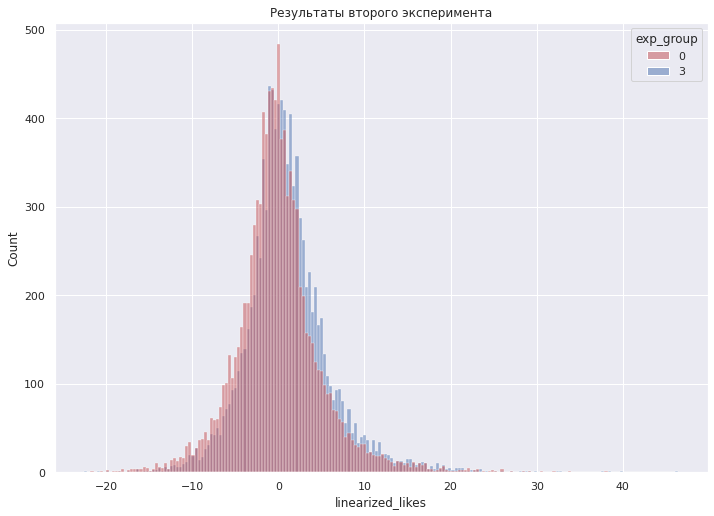

In [13]:
# Второй эксперимент
groups = sns.histplot(
    data=ab_test_data_2, 
    x='linearized_likes', 
    hue='exp_group', 
    palette=['r', 'b'],
    alpha=0.5,
    kde=False
)
plt.title('Результаты второго эксперимента');

## Тесты

### Первый эксперимент

In [14]:
# на поюзерном CTR
stats.ttest_ind(ab_test_data_1[ab_test_data_1['exp_group'] == 2]['ctr'], # test
                ab_test_data_1[ab_test_data_1['exp_group'] == 1]['ctr'], # control
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.4780623130874935)

In [15]:
# на линеаризированных лайков
stats.ttest_ind(ab_test_data_1[ab_test_data_1['exp_group'] == 2]['linearized_likes'], # test
                ab_test_data_1[ab_test_data_1['exp_group'] == 1]['linearized_likes'], # control
                equal_var=False)

Ttest_indResult(statistic=-6.122579994775974, pvalue=9.439432187037644e-10)

На линеаризированный лайках метрика прокрасилась, в отличии от поюзерного CTR.  
На линеаризированный лайках p-value стало меньше на порядок.

### Второй эксперимент

In [16]:
# на поюзерном CTR
stats.ttest_ind(ab_test_data_2[ab_test_data_2['exp_group'] == 3]['ctr'], # test
                ab_test_data_2[ab_test_data_2['exp_group'] == 0]['ctr'], # control
                equal_var=False)

Ttest_indResult(statistic=13.896870721904069, pvalue=1.055849414662529e-43)

In [17]:
# на линеаризированных лайков
stats.ttest_ind(ab_test_data_2[ab_test_data_2['exp_group'] == 3]['linearized_likes'], # test
                ab_test_data_2[ab_test_data_2['exp_group'] == 0]['linearized_likes'], # control
                equal_var=False)

Ttest_indResult(statistic=15.214995460903827, pvalue=5.4914249479690016e-52)

Обе метрики прокрасились.  
На линеаризированный лайках p-value стало меньше на порядок.

Выглядит впечатляюще.

### Интересно посмотреть еще тест Манна Уитни

### Первый эксперимент

In [18]:
stats.mannwhitneyu(ab_test_data_1[ab_test_data_1['exp_group'] == 2]['ctr'],
                   ab_test_data_1[ab_test_data_1['exp_group'] == 1]['ctr'],
                   alternative='two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

In [19]:
stats.mannwhitneyu(ab_test_data_1[ab_test_data_1['exp_group'] == 2]['linearized_likes'],
                   ab_test_data_1[ab_test_data_1['exp_group'] == 1]['linearized_likes'],
                   alternative='two-sided')

MannwhitneyuResult(statistic=45771671.0, pvalue=9.404319579641738e-27)

### Второй эксперимент

In [20]:
stats.mannwhitneyu(ab_test_data_2[ab_test_data_2['exp_group'] == 3]['ctr'], # test
                   ab_test_data_2[ab_test_data_2['exp_group'] == 0]['ctr'], # control
                   alternative='two-sided')

MannwhitneyuResult(statistic=56797159.0, pvalue=1.1952055473582936e-57)

In [21]:
stats.mannwhitneyu(ab_test_data_2[ab_test_data_2['exp_group'] == 3]['linearized_likes'], # test
                   ab_test_data_2[ab_test_data_2['exp_group'] == 0]['linearized_likes'], # control
                   alternative='two-sided')

MannwhitneyuResult(statistic=57141625.0, pvalue=1.1517315029786597e-63)

В тестах Манна-Уитни p-value стало больше. Наверное это из-за того, что распределения немного изменились и стали более "похожими".